# Building a model that predicts phishing webpages 

This file contains codes which builds a binary classification model to distinguish phishing from legitimate webpages. Here, the features are evaluated using a number of ML algorithms to identify the best performing features, the best performing algorithm and the optimal prediction performance. In this notebook, the followin tasks are performed;
1. Importing of libraries and data file
2. Observing data description and statistics
3. Data cleaning
4. Data exploration
5. Feature encoding
6. Analysis of feature dependencies
7. Feature selection
8. Model evaluation
9. ROC analysis
10. Hyperparameter tuning


## Importing Libraries and Data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import category_encoders as ce
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold  # a CV with folds where each one contains the same ratio of classes as in general dataset
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict  # for generating confusion matrix with CV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier,XGBRFClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings("ignore")

file = 'C:/Users/tomna/OneDrive/Datasets/Model 1 Rework/Dataset - Phase 2/Combined/Dataset_Final.csv'
df = pd.read_csv(file)

## Data Description

In [47]:
df.head()

DomainIdentityInPage DomainIdentityInCopyright DomainIdentityInCanonical  \
0                    10                      Null                      Null   
1                    13                        No                       Yes   
2                     1                        No                       Yes   
3                   111                       Yes                       Yes   
4                   103                       Yes                       Yes   

  DomainIdentityInAlternate ForeignHyperlinks  VoidHyperlinkRatio  \
0                      Null               Yes                0.00   
1                      Null               Yes                0.00   
2                      Null               Yes                0.12   
3                       Yes               Yes                0.07   
4                       Yes               Yes                0.03   

  ForeignFormHandler IPInURL  NumericFQDN  NumericPath  ... FHDomainValidity  \
0           Internal      No            1            0  ...              Yes   
1           Internal      No            0            0  ...              Yes   
2           Internal      No            0            0  ...              Yes   
3           Internal      No            0            1  ...              Yes   
4           Internal      No            0            1  ...              Yes   

   FHDomainAge SSLCertificateType SSLGeoCountryMatch  URLSearchEngineRanking  \
0         8832                 OV                 No                     Yes   
1         4984                 OV                Yes                     Yes   
2         1909                 OV                Yes                     Yes   
3         8334                 OV                Yes                      No   
4         8334                 OV                Yes                      No   

   DomainSearchEngineRanking FQDNSearchEngineRanking  FQDNBlacklistIPCounts  \
0                        Yes                     Yes                      0   
1                        Yes                     Yes                      0   
2                        Yes                     Yes                      0   
3                        Yes                     Yes                      0   
4                        Yes                     Yes                      0   

   DomainBlacklistIPCounts       Class  
0                        0  Legitimate  
1                        0  Legitimate  
2                        0  Legitimate  
3                        0  Legitimate  
4                        0  Legitimate  

[5 rows x 36 columns]

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26114 entries, 0 to 26113
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DomainIdentityInPage       26114 non-null  int64  
 1   DomainIdentityInCopyright  26114 non-null  object 
 2   DomainIdentityInCanonical  26114 non-null  object 
 3   DomainIdentityInAlternate  26114 non-null  object 
 4   ForeignHyperlinks          26114 non-null  object 
 5   VoidHyperlinkRatio         26114 non-null  float64
 6   ForeignFormHandler         26114 non-null  object 
 7   IPInURL                    26114 non-null  object 
 8   NumericFQDN                26114 non-null  int64  
 9   NumericPath                26114 non-null  int64  
 10  DomainEncoding             26114 non-null  object 
 11  PathEncodedCharacters      26114 non-null  int64  
 12  RedirectionalChar          26114 non-null  object 
 13  OutPositionedDomain        26114 non-null  obj

In [49]:
df.shape

(26114, 36)

There are 36 columns, 35 are the features and the last column 'Class' is a target. 16 features are numerical, 19 are non-numerical.
Total number of rows is 26,114.

Checking distribution/ratio of classes. The  binary classes are nearly balanced.

In [50]:
df['Class'].value_counts()

Legitimate    13494
Phishing      12620
Name: Class, dtype: int64

Identifying numerical and non-numerical columns

In [51]:
numeric_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()

## Data Cleaning

Identifying missing values represented with other values other than NaN and converting them to the latter

In [52]:
# identify unique value of each categorical feature
for col in categorical_cols :
        print(col, '\n', df[col].unique())

DomainIdentityInCopyright 
 ['Null' 'No' 'Yes']
DomainIdentityInCanonical 
 ['Null' 'Yes' 'No' 'Void']
DomainIdentityInAlternate 
 ['Null' 'Yes' 'No' 'Void']
ForeignHyperlinks 
 ['Yes' 'No']
ForeignFormHandler 
 ['Internal' 'External']
IPInURL 
 ['No' 'Yes']
DomainEncoding 
 ['No']
RedirectionalChar 
 ['No' 'Yes']
OutPositionedDomain 
 ['No' 'Yes']
NonStandardPort 
 ['Null' 'Yes' 'No']
ShortURL 
 ['No' 'Yes']
SubdomainService 
 ['No' 'Yes']
DomainNameValidity 
 ['Yes' 'Unknown' 'No']
FHDomainValidity 
 ['Yes' 'Unknown' 'No']
SSLCertificateType 
 ['OV' 'DV' 'EV' 'Null' nan]
SSLGeoCountryMatch 
 ['No' 'Yes' 'Unknown']
URLSearchEngineRanking 
 ['Yes' 'No']
DomainSearchEngineRanking 
 ['Yes' 'No']
FQDNSearchEngineRanking 
 ['Yes' 'No']
Class 
 ['Legitimate' 'Phishing']


Replace Null, Void and Unknown values observed above with NaN

In [53]:
df.replace(['Null','Void','Unknown'],np.nan,inplace=True)

Identifying values that are below 0 in each numerical feature

In [54]:
for col in numeric_cols :
    list_unique_value_col = df[col].unique()
    sublist_unique_value_col = [x for x in list_unique_value_col if x < 0]    # get values less than 0
    if sublist_unique_value_col:
        print(col, '-', sorted(sublist_unique_value_col,reverse=True)) 

VoidHyperlinkRatio - [-1.0]
DomainAge - [-1, -8]
FHDomainAge - [-1, -8]


Replace -1 and -8 spotted above with NaN

In [55]:
df.replace([-1.0,-1,-8],np.nan,inplace=True)

Plot percentages of missing values for features with at least one missing value

<AxesSubplot:title={'center':'% of Missing Values in Columns'}>

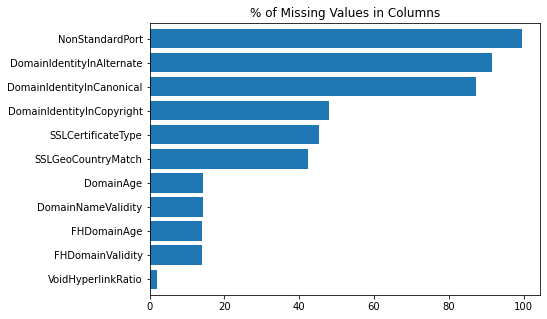

In [56]:
df_null_cols = round((df.isnull().sum()/df.shape[0]*100), 1).sort_values(ascending=True) 
df_null_cols[df_null_cols > 0.0].plot.barh(figsize=(7,5),title='% of Missing Values in Columns',width=0.8)   # plot % of missing values by columns

Dropping all columns with at least 50% missing values

In [57]:
df_null_cols_del = df_null_cols[df_null_cols > 50.0]
cols_del = df_null_cols_del.index.to_list()   # return a list of columns to be deleted
df.drop(cols_del,axis = 1,inplace = True)  
print('Dropped features: ', cols_del)

Dropped features:  ['DomainIdentityInCanonical', 'DomainIdentityInAlternate', 'NonStandardPort']


Replacing missing values in all columns with imputed values

In [58]:
# updating the list of columns after deleting some of them in the previous step
numeric_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
# imputing the numerical columns
imputer = SimpleImputer(strategy='median',missing_values=np.nan)
imputer = imputer.fit(df[numeric_cols])
df[numeric_cols] = imputer.transform(df[numeric_cols])
# imputing the categorical columns
imputer = SimpleImputer(strategy='constant',missing_values=np.nan,fill_value='Unknown')
imputer = imputer.fit(df[categorical_cols])
df[categorical_cols] = imputer.transform(df[categorical_cols])

Checking and removing duplicated records

In [59]:
original_rows = df.shape[0]
df.drop_duplicates(keep='first',inplace=True)
new_rows = df.shape[0]
print('Deleted number of duplicated rows: ', original_rows - new_rows)

Deleted number of duplicated rows:  720


Identifying and removing irrelevant columns; those which have only one unique value

In [60]:
cols = df.columns.to_list()
# get fractions (%) of unique values for each column sorted by the largest
# if the fraction is 1, this means the column has only one unique value thus irrelevant for prediction
print('Irrelevant column(s) dropped: ')
for col in cols :
    counts_unique_values = round(df[col].value_counts(sort=True, normalize=True),3)  
    if counts_unique_values.iloc[0] == 1.0 :
        print(col)
        df.drop([col],axis = 1,inplace=True)  # drop column with one unique value only

Irrelevant column(s) dropped: 
DomainEncoding


Identifying outliers in continous columns

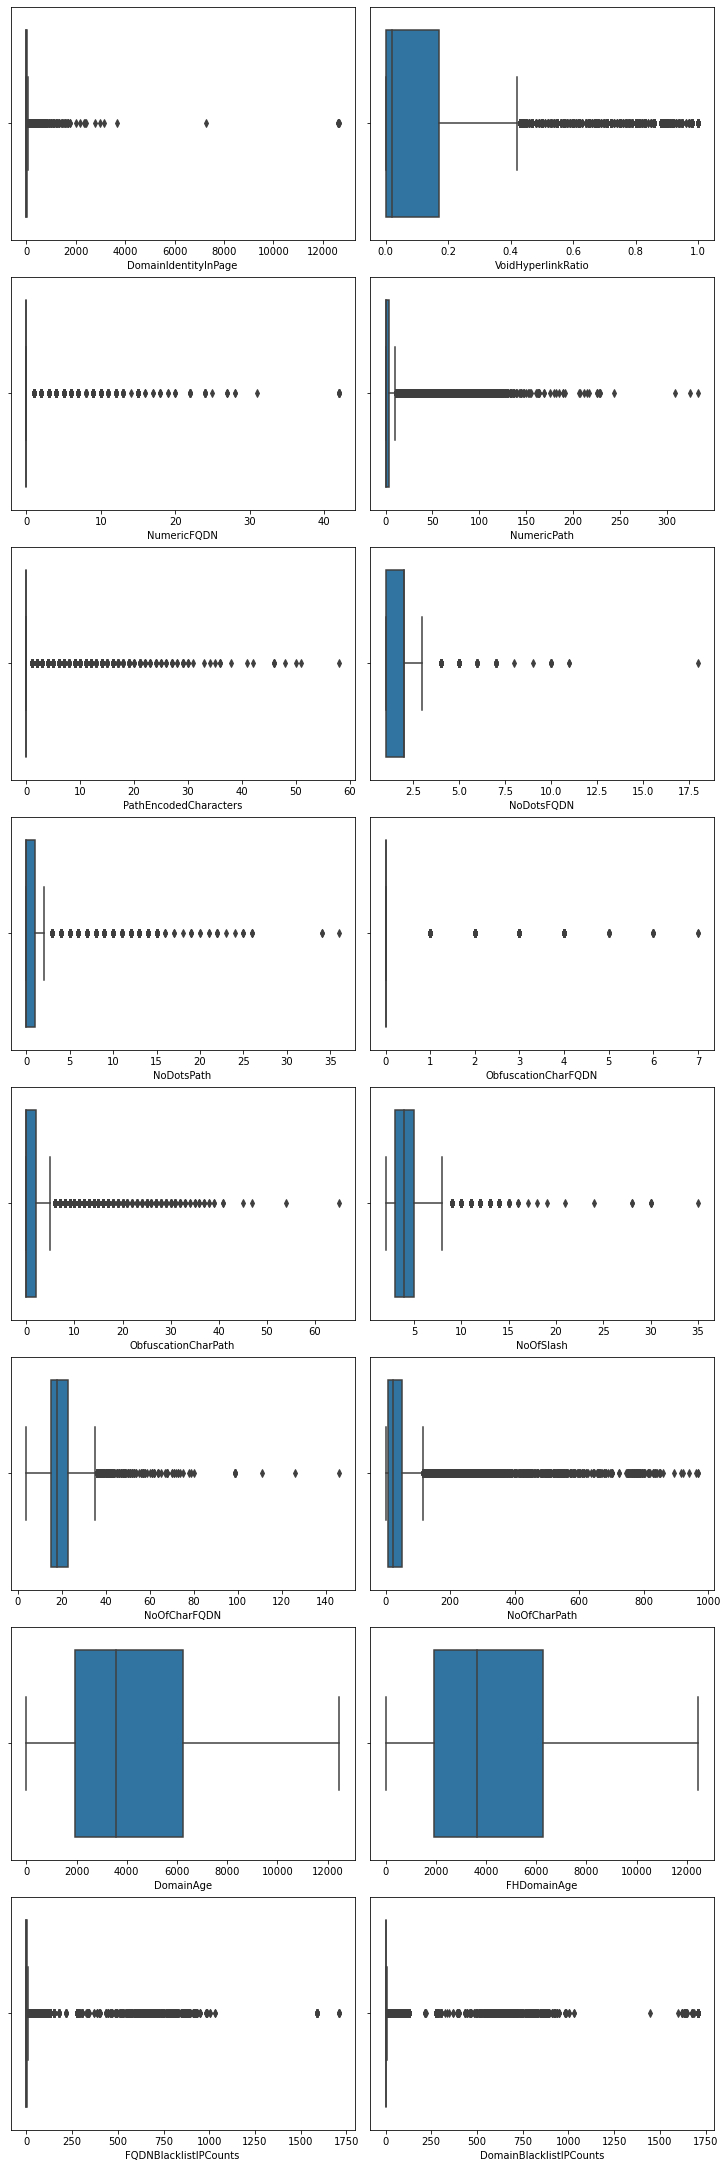

In [61]:
fig,axes = plt.subplots(8,2,figsize=(10,30),constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
axes = axes.flatten()
for col in numeric_cols :
    sns.boxplot(df[col],ax=axes[numeric_cols.index(col)])
# suspected outliers were noted in most numerical data but they are not errors thus not deleted.

There are potential outliers in most columns. However, these are actual values and not due to errors based on the method we used to collect data and our domain knowledge. Therefore, we leave them as they are.

## Data Exploration
Here, we analyze relationships of columns of the cleaned dataset using various graphical plots. We use pairplots to understand relationships between each pair of features, histograms to analyze data distribution of numerical data and bar plots to investigate the distribution of categorical features

<Figure size 3600x3600 with 0 Axes>

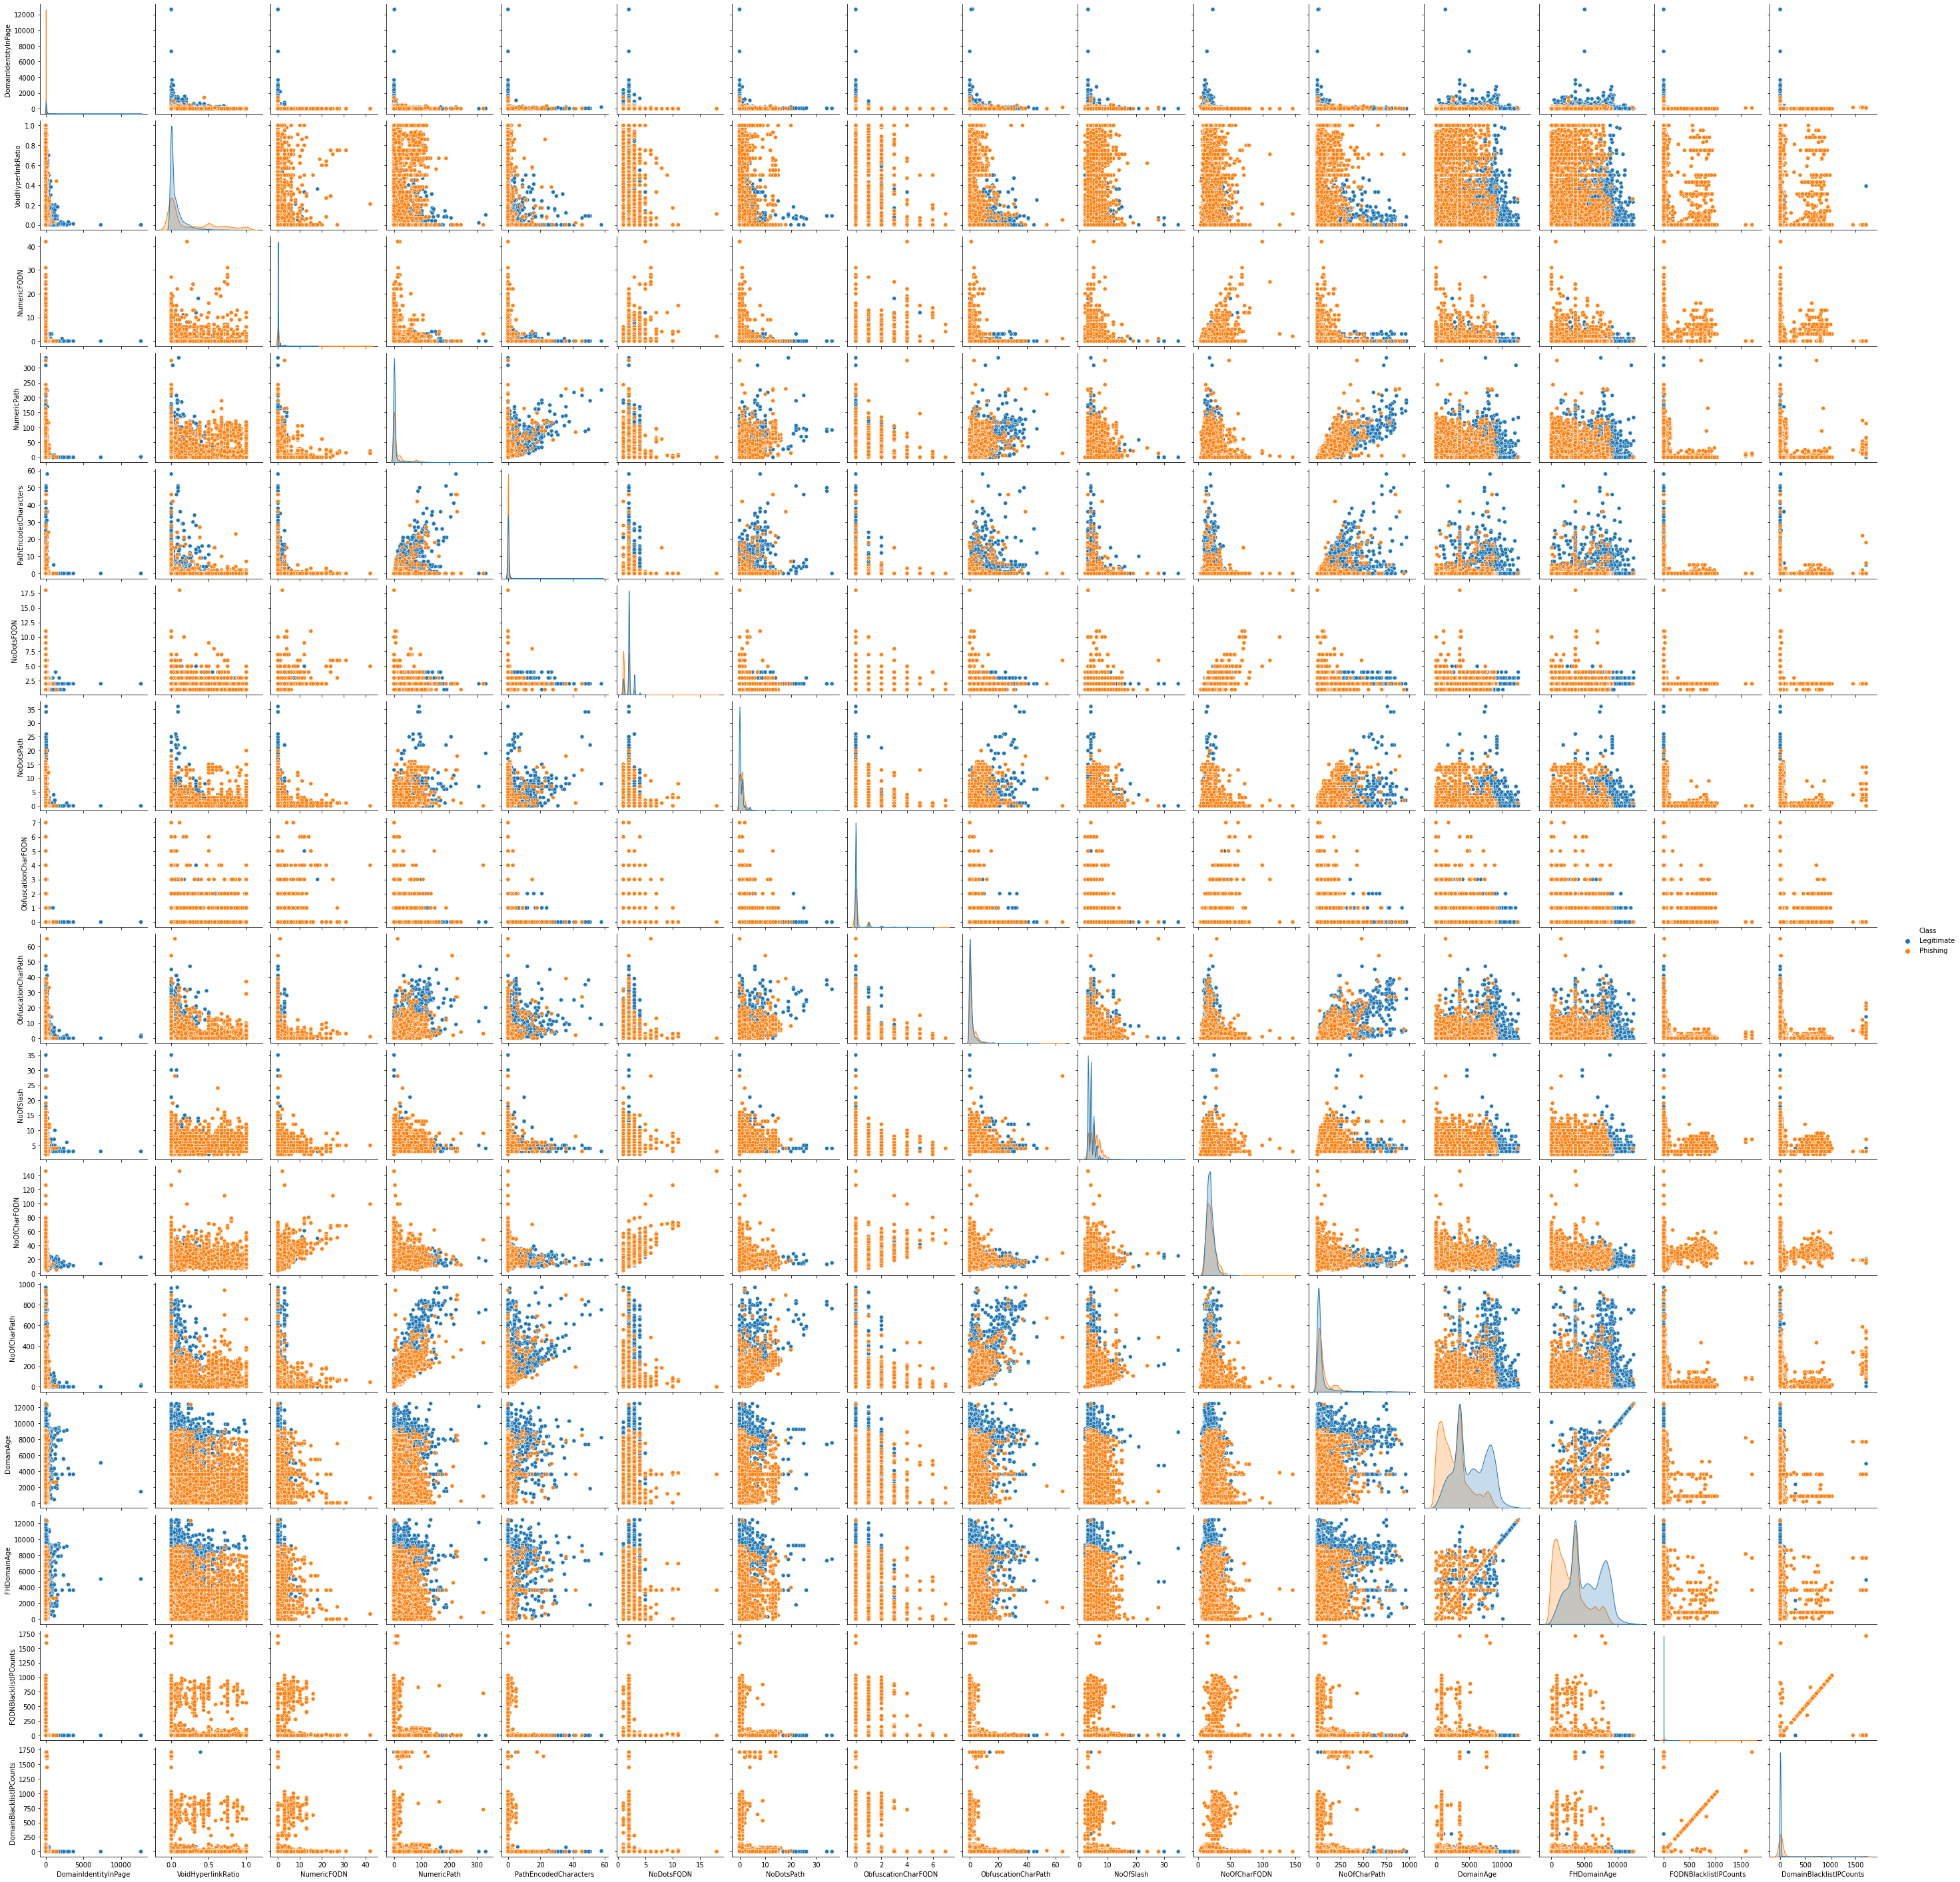

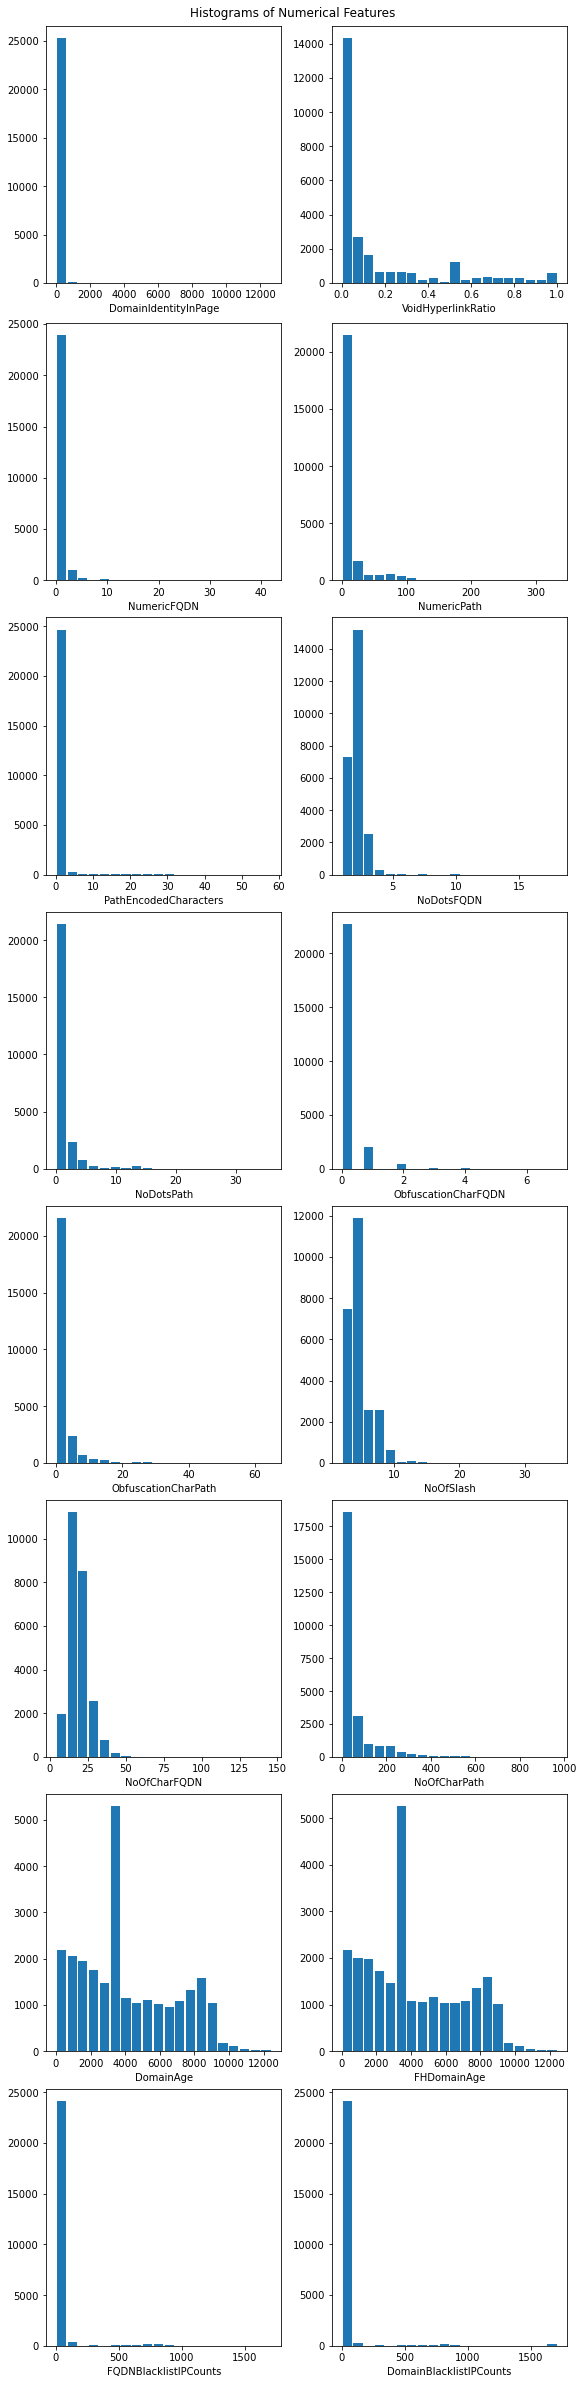

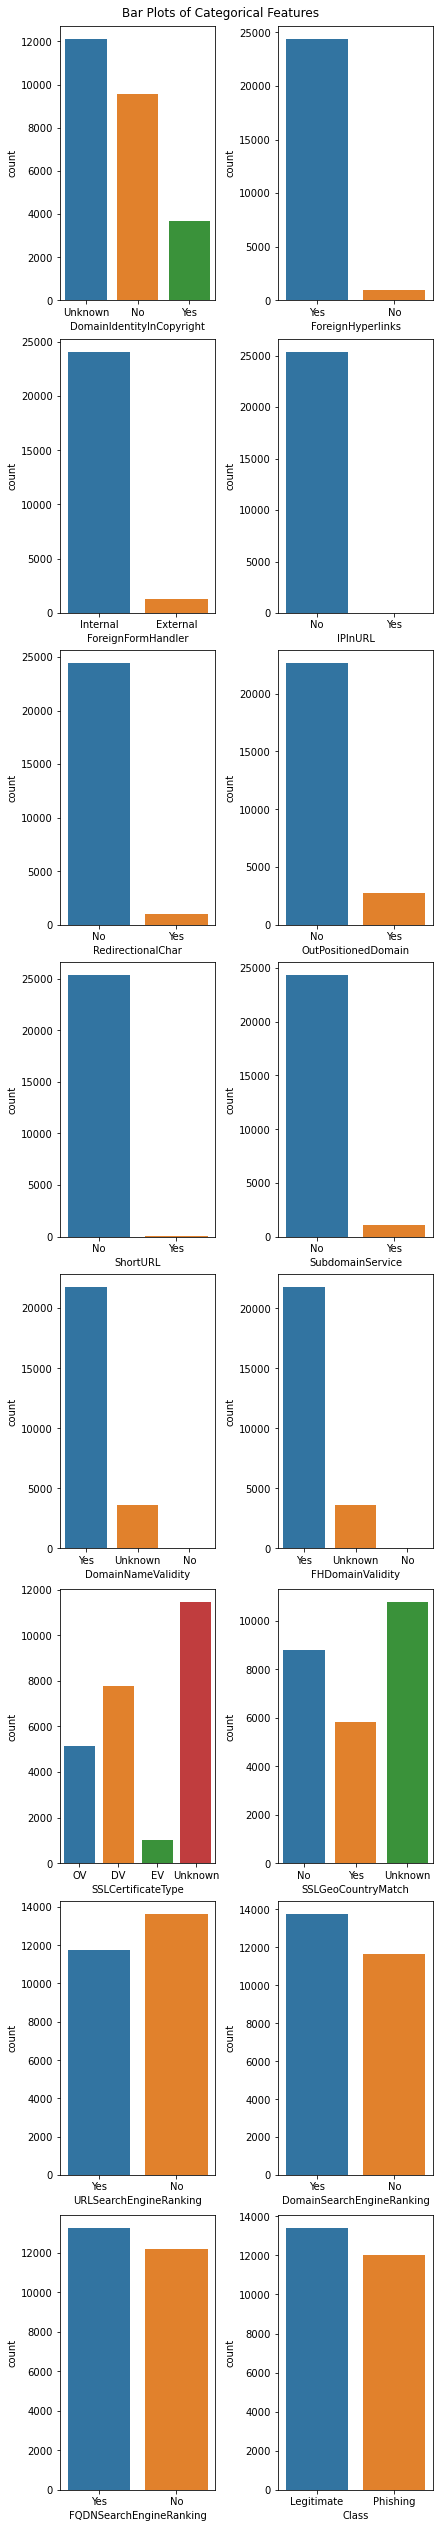

In [62]:
numeric_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()

# plotting pair plots of numerical features
plt.figure(figsize=(50,50))
plt.suptitle('Pair Plots of Numerical Features')
sns.pairplot(df,hue='Class')  # subplots of each pair of numerical columns in one grid plot.Default is scatter plot
plt.show()
print('\n')

# plotting histograms of categorical features
fig,axes = plt.subplots(8,2,figsize=(8,33),constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
#plt.subplots_adjust(top=.8)
plt.suptitle("Histograms of Numerical Features")
axes = axes.flatten()
for col in numeric_cols :
    sns.distplot(df[col],ax=axes[numeric_cols.index(col)],kde=False,bins=20,hist_kws={"rwidth":0.85,"alpha": 1})
plt.show()
print('\n')

# plotting bar plots of categorical features
fig,axes = plt.subplots(8,2,figsize=(6,35),constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
#plt.subplots_adjust(top=.8)
plt.suptitle("Bar Plots of Categorical Features")
axes = axes.flatten()
for col in categorical_cols :
    sns.countplot(df[col],ax=axes[categorical_cols.index(col)])
plt.show()
print('\n')


The pair plot shows various types of relationships between the features. There are few linear relationships for instance between DomainBlacklistCounts and FQDNBlacklistCounts while some of the features have no correlations. The histograms indicates that most of the features have low value range while a few of them have fairly wide distribution of values. In most categorical features, there are significant unequal distribution of values whereas in a few features there is balanced distribution of unique values across the dataset.

## Feature Encoding

Converting categorical columns into numeric values

In [63]:
# Since all the features and target have low cardinality (few unique values) - max is 4, one hot encoding can be applied to each
    # first, the list of columns is updated after dropping irrelevant columns in the previous steps
numeric_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
    # label encoding the target column
encoded_target= ce.OrdinalEncoder(cols=['Class'], return_df=True, mapping=[{'col':'Class','mapping':{'Legitimate':0,'Phishing':1}}])   
df = encoded_target.fit_transform(df)
    # one hot encoding the features
feature_cols = categorical_cols
del feature_cols[-1]   # delete the last column 'Class'
encoded_cols= ce.OneHotEncoder(cols=feature_cols)
df = encoded_cols.fit_transform(df)

## Feature Dependencies
Investigating correlations among the columns

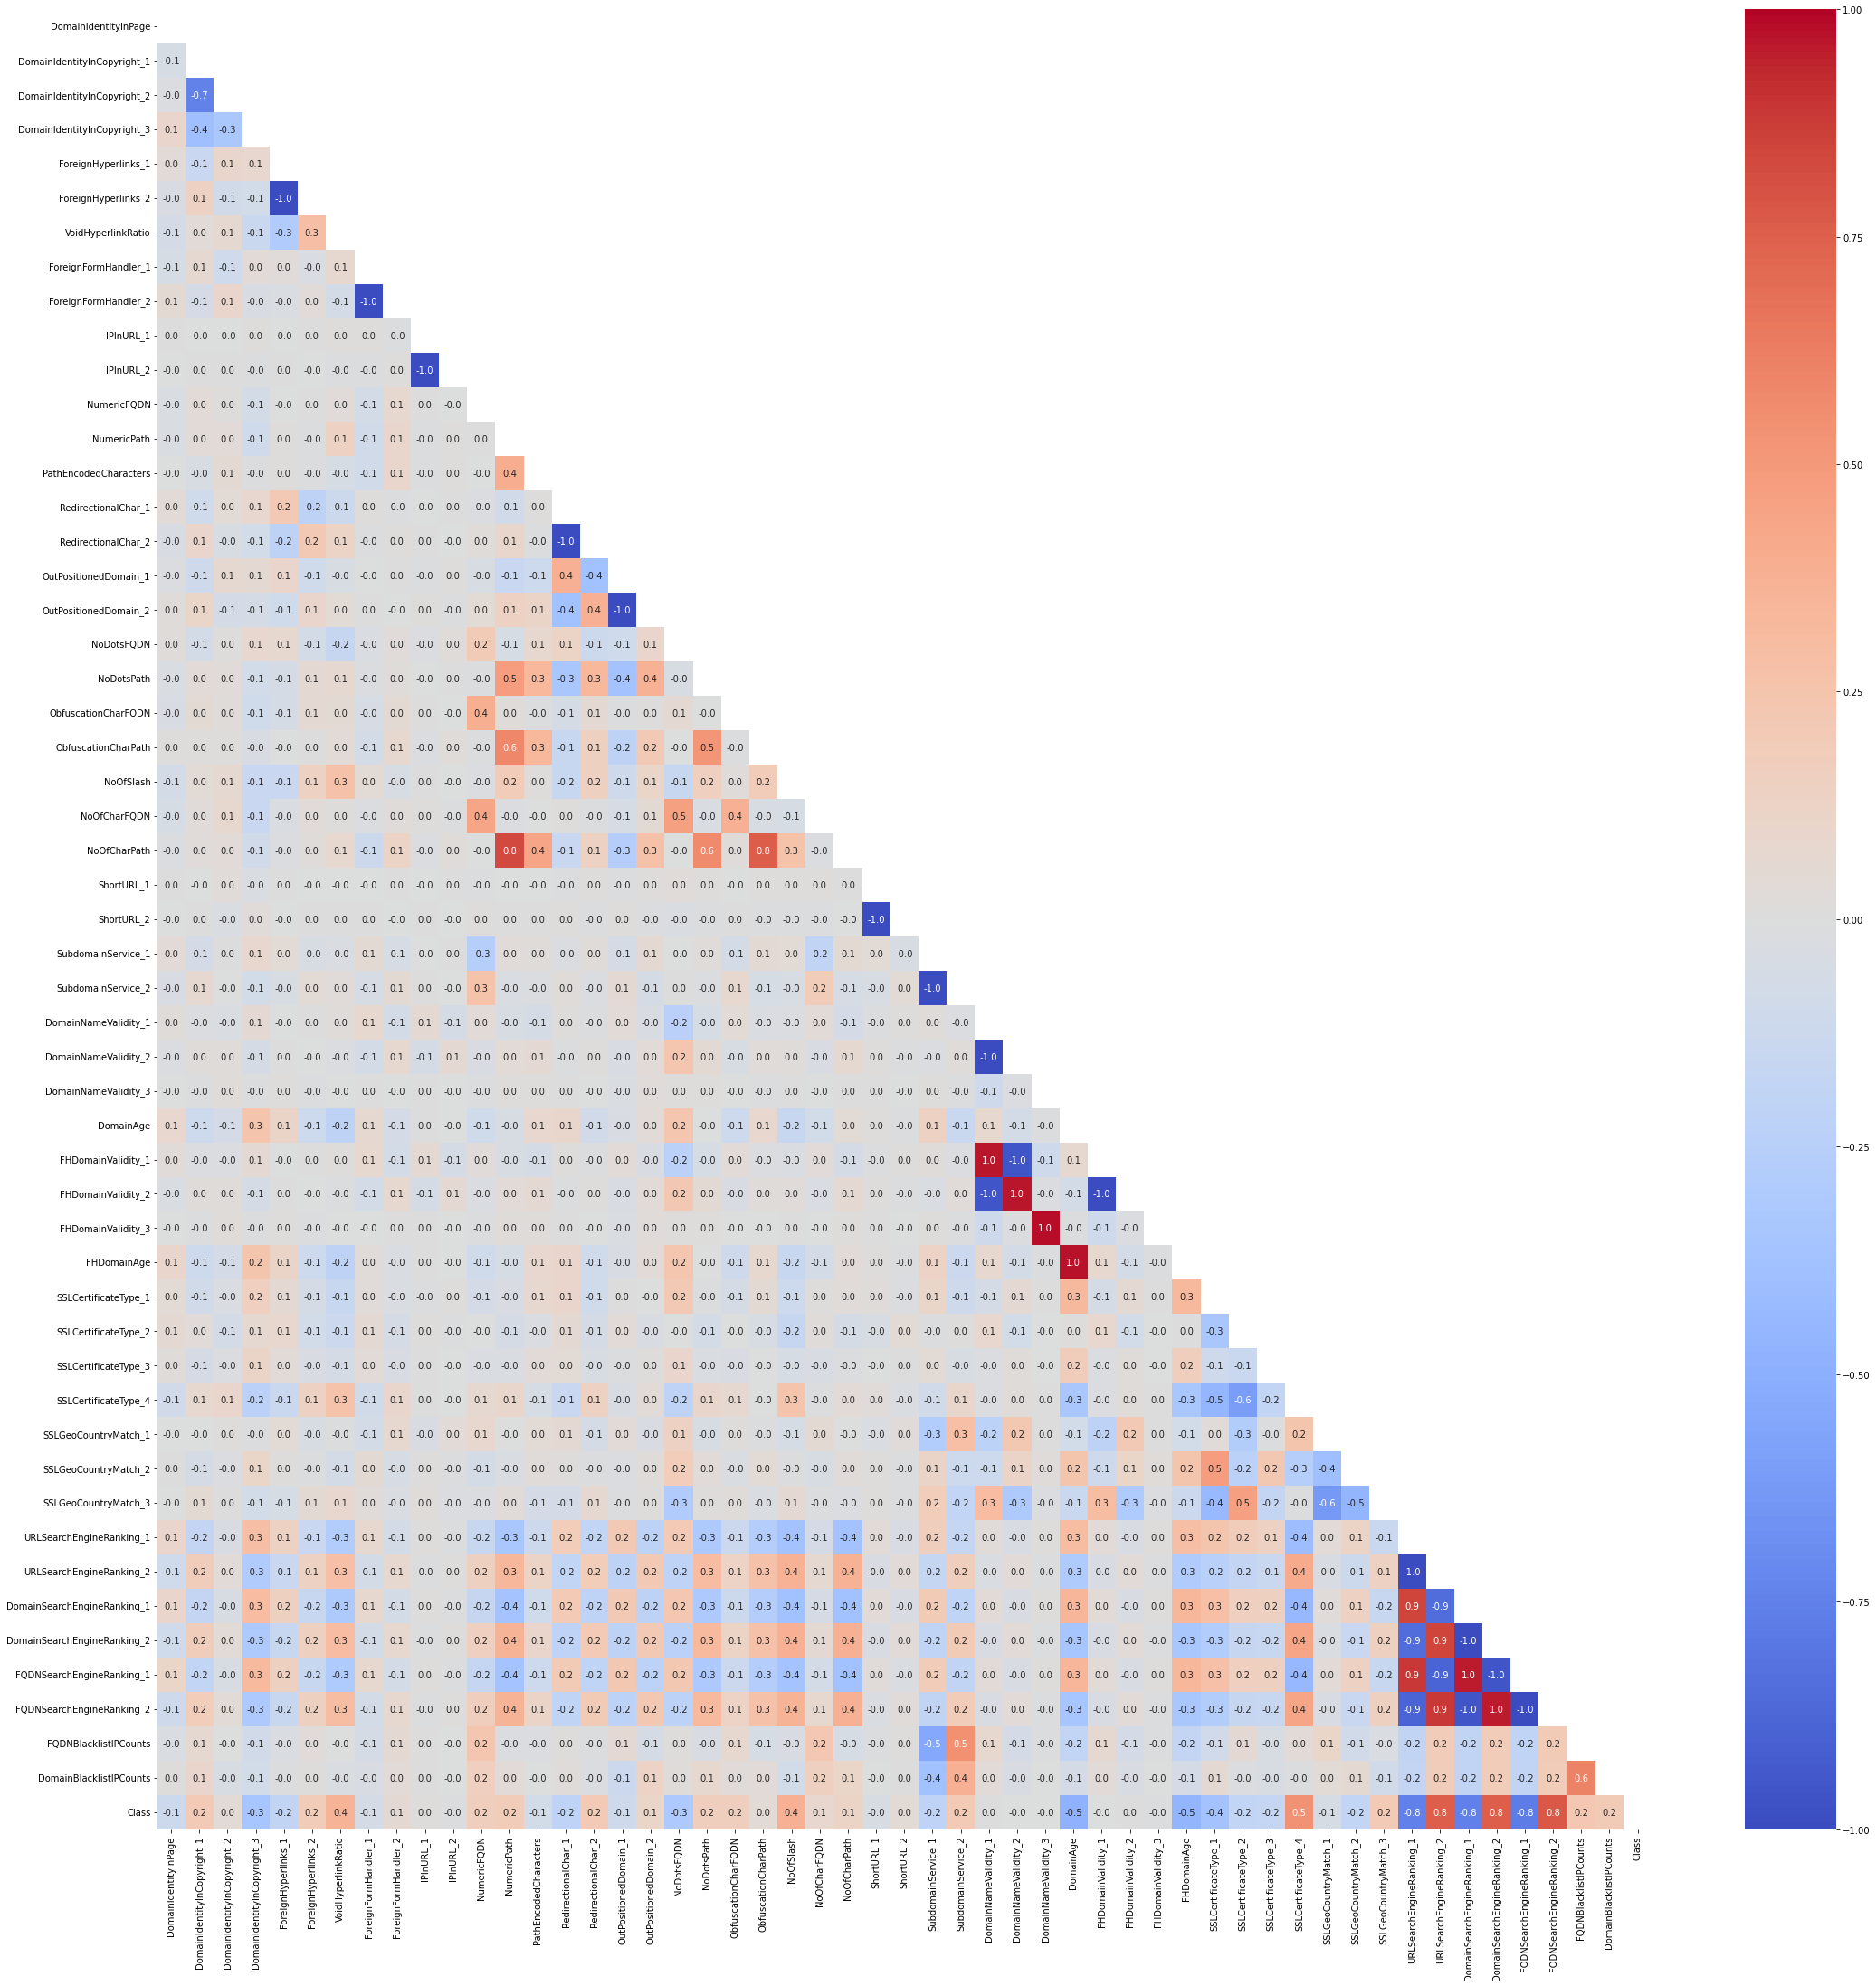

In [64]:
plt.figure(figsize=(37,37))
corr_matrix = df.corr()
mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
image = sns.heatmap(corr_matrix, annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask) # annot=show numbers, fmt='.1f'= show 1 number of decimal places

Columns FHDomainAge, FHDomainValidity and DomainSearchEngineRanking are observed to have correlation coefficients of 1.0 with other columns, therefore they are dropped

In [65]:
df.drop(['FHDomainAge','FHDomainValidity_1','FHDomainValidity_2','FHDomainValidity_3','DomainSearchEngineRanking_1','DomainSearchEngineRanking_2'],axis=1,inplace=True)

## Splitting Prediction and Target Variables
We split the dataset into prediction features and a target

In [72]:
df = shuffle(df)
X = df.drop(["Class"],axis=1)
y = df["Class"]
print('Number of Features before selection: ', len(X.columns.to_list()))

Number of Features before selection:  46


## Feature Selection
Recursive Feature Elimination (RFE) is used to automatically identify the best predictive features

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
kf = StratifiedKFold(n_splits=10,random_state=2,shuffle=True)
rfecv = RFECV(estimator=RandomForestClassifier(),min_features_to_select=3, cv=kf, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])
for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
df_features.sort_values(by='ranking')
df_features = df_features[df_features['support']==True]  # selected best features always give support value as True
best_features = df_features['feature'].tolist()  # get all values of the column
print("No features after feature selection : ", len(df_features['feature']))
X = df[best_features]

No features after feature selection :  36


## Model Evaluation
Various traditional ML algorithms for classification are used to evaluate the dataset in order to compare their performances and identify the best performing algorithms for the task. Seven different performance metrics are used to report and compare the algorithms

In [74]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=4)))
models.append(('LGBM', LGBMClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state=20)))
models.append(('XGB', XGBClassifier()))
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
for name,model in models:
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    accurs = []
    precs = []
    recs = []
    f1s = []
    FPRs = []
    FNRs = []
    aucs = []
    for train_index, test_index in rkf.split(X, y):
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = model.score(X_test_scaled, y_test)
        accurs.append(accuracy)
        precision = precision_score(y_test, y_pred)
        precs.append(precision)
        recall = recall_score(y_test, y_pred)
        recs.append(recall)
        f1 = f1_score(y_test, y_pred)
        f1s.append(f1)
        if name == 'SVM' :
            auc = roc_auc_score(y_test, model.decision_function(X_test_scaled))
        else: 
            auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        aucs.append(auc)
        cm = confusion_matrix(y_test, y_pred)
        TN = TN + cm[0,0]
        TP = TP + cm[1,1]
        FN = FN + cm[1,0]
        FP = FP + cm[0,1]
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    accur_mean = round((np.mean(accurs)*100),2)
    prec_mean = round(np.mean(precs),2)
    recall_mean = round(np.mean(recs),2)
    f1_mean = round(np.mean(f1s),2)
    AUC_mean = round(np.mean(aucs),2)
    print(name, ' -- Accuracy :', round((np.mean(accurs)*100),2),'%', ' | FPR :', round(FPR*100,2),'% | FNR :', round(FNR*100,2),'% | Precision :', prec_mean,' | Recall :', recall_mean,' | F1 :', f1_mean,' | AUC :', AUC_mean )

LR  -- Accuracy : 95.33 %  | FPR : 3.31 % | FNR : 6.19 % | Precision : 0.96  | Recall : 0.94  | F1 : 0.95  | AUC : 0.99
KNN  -- Accuracy : 96.06 %  | FPR : 2.74 % | FNR : 5.28 % | Precision : 0.97  | Recall : 0.95  | F1 : 0.96  | AUC : 0.98
DT  -- Accuracy : 97.35 %  | FPR : 2.58 % | FNR : 2.73 % | Precision : 0.97  | Recall : 0.97  | F1 : 0.97  | AUC : 0.97
NB  -- Accuracy : 92.97 %  | FPR : 4.04 % | FNR : 10.36 % | Precision : 0.95  | Recall : 0.9  | F1 : 0.92  | AUC : 0.97
SVM  -- Accuracy : 96.58 %  | FPR : 2.36 % | FNR : 4.6 % | Precision : 0.97  | Recall : 0.95  | F1 : 0.96  | AUC : 0.99
NN  -- Accuracy : 97.08 %  | FPR : 2.36 % | FNR : 3.55 % | Precision : 0.97  | Recall : 0.96  | F1 : 0.97  | AUC : 0.99
RF  -- Accuracy : 98.47 %  | FPR : 1.17 % | FNR : 1.94 % | Precision : 0.99  | Recall : 0.98  | F1 : 0.98  | AUC : 1.0
LGBM  -- Accuracy : 98.55 %  | FPR : 1.05 % | FNR : 1.9 % | Precision : 0.99  | Recall : 0.98  | F1 : 0.98  | AUC : 1.0
GB  -- Accuracy : 97.98 %  | FPR : 1.38 

## ROC Analysis

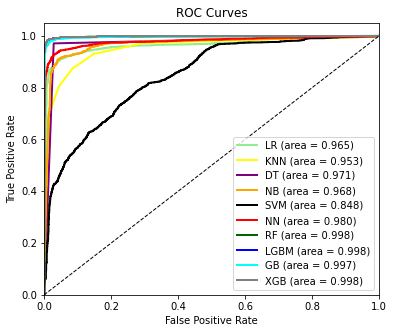

In [75]:
names = []
accurs =  []
precs = []
recs = []
f1s = []
aucs = []
fprs = []
tprs = []
roc_aucs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)  # we have a new X that is already standardized
for name,model in models:
    names.append(name)
    model.fit(X_train, y_train)
    if name =='SVM' :  
        y_pred_prob = model.decision_function(X_test)
    else :
        y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,pos_label=1) 
    auc = roc_auc_score(y_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc)     
colors = ['lightgreen', 'yellow','purple','orange','black','red','darkgreen','blue','cyan','gray']
plt.figure(figsize=(6,5))
for i in range(0, len(names)) :
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=names[i] +' (area = %0.3f)' % roc_aucs[i])
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

Comparing performances of the algorithms in the above two sections, XGBoost (XGB) is observed to outperform the rest across most of the metrics. We therefore tune the algorithm in the next section in search of an optimal performance

## Hyperparameter Tuning


In [76]:
warnings.filterwarnings("ignore")
time_start = time.time()
params = { 
    'XGB__n_estimators' : [300,400,500,600,700,800,900,1000], 
    # Learning rate shrinks the weights to make the boosting process more conservative
    'XGB__learning_rate': [0.0001,0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    'XGB__max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
    'XGB__min_child_weight' : [ 3, 5, 7, 9 ],
    # Gamma specifies the minimum loss reduction required to make a split.
    'XGB__gamma': [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    'XGB__colsample_bytree': [i/10.0 for i in range(3,10)],
    'XGB__subsample': [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    'XGB__reg_alpha': [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    'XGB__reg_lambda': [1e-5, 1e-2, 0.1, 1, 10, 100] 
        }
xgb = XGBClassifier(random_state=123)
kf = StratifiedKFold(n_splits = 10) 
grid = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=100, cv=kf, random_state=8, verbose=0,n_jobs=-1)
grid.fit(X_train, y_train)
print('Best Params:', grid.best_params_)
model = grid.best_estimator_   # get the best model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)
TP = TN = FP = FN = 0
TN = TN + cm[0,0]
TP = TP + cm[1,1]
FN = FN + cm[1,0]
FP = FP + cm[0,1]
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print('Accuracy :', round((accuracy*100),2),'%', ' | FPR :', round(FPR*100,2),'% | FNR :', round(FNR*100,2), '% | Precision :', round(precision,2),' | Recall :', round(recall,2),' | F1 :', round(f1,2),' | AUC :', round(auc,2))
time_end = time.time()
execTime = time_end - time_start 
print('Time :' , round(execTime/3600,2), ' hrs')

[11:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "XGB__colsample_bytree", "XGB__gamma", "XGB__learning_rate", "XGB__max_depth", "XGB__min_child_weight", "XGB__n_estimators", "XGB__reg_alpha", "XGB__reg_lambda", "XGB__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Params: {'XGB__subsample': 0.5, 'XGB__reg_lambda': 1, 'XGB__reg_alpha': 10, 'XGB__n_estimators': 1000, 'XGB__min_child_weight': 9, 'XGB__max_depth': 6, 'XGB__learning_rate': 0.0001, 'XGB__gamma': 0.1, 'XGB__colsample_bytree': 0.9}
Accuracy : 98.64 %  | FPR : 1.02 % | FNR : 1.76 % | Precision : 0.99  | Recall : 0.98  | F1 : 0.99  | AUC : 1.0
Time : 0.43  hrs


Using Random search method, best hyperparameters are identified which have improved the performance of the XGB algorithm across most of the metrics compared to the default hyperparameters